# 3-4. 일단 제출하고 시작해! Baseline 모델 (1) Baseline 셋팅하기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 3-5. 일단 제출하고 시작해! Baseline 모델 (2) 라이브러리, 데이터 가져오기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data_path = './data/train.csv'
test_data_path = './data/test.csv'

# 3-6. 일단 제출하고 시작해! Baseline 모델 (3) 데이터 이해하기

In [5]:
# ✓ 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)
print(data.shape)
print(sub.shape)

(15035, 21)
(6468, 20)


In [6]:
#✓ 학습 데이터에서 라벨 제거하기
y = data['price']
del data['price']
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# ✓ 학습 데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data,sub),axis=0)
print(len(data))

21503


In [8]:
data.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

In [9]:
# ✓ 간단한 전처리
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

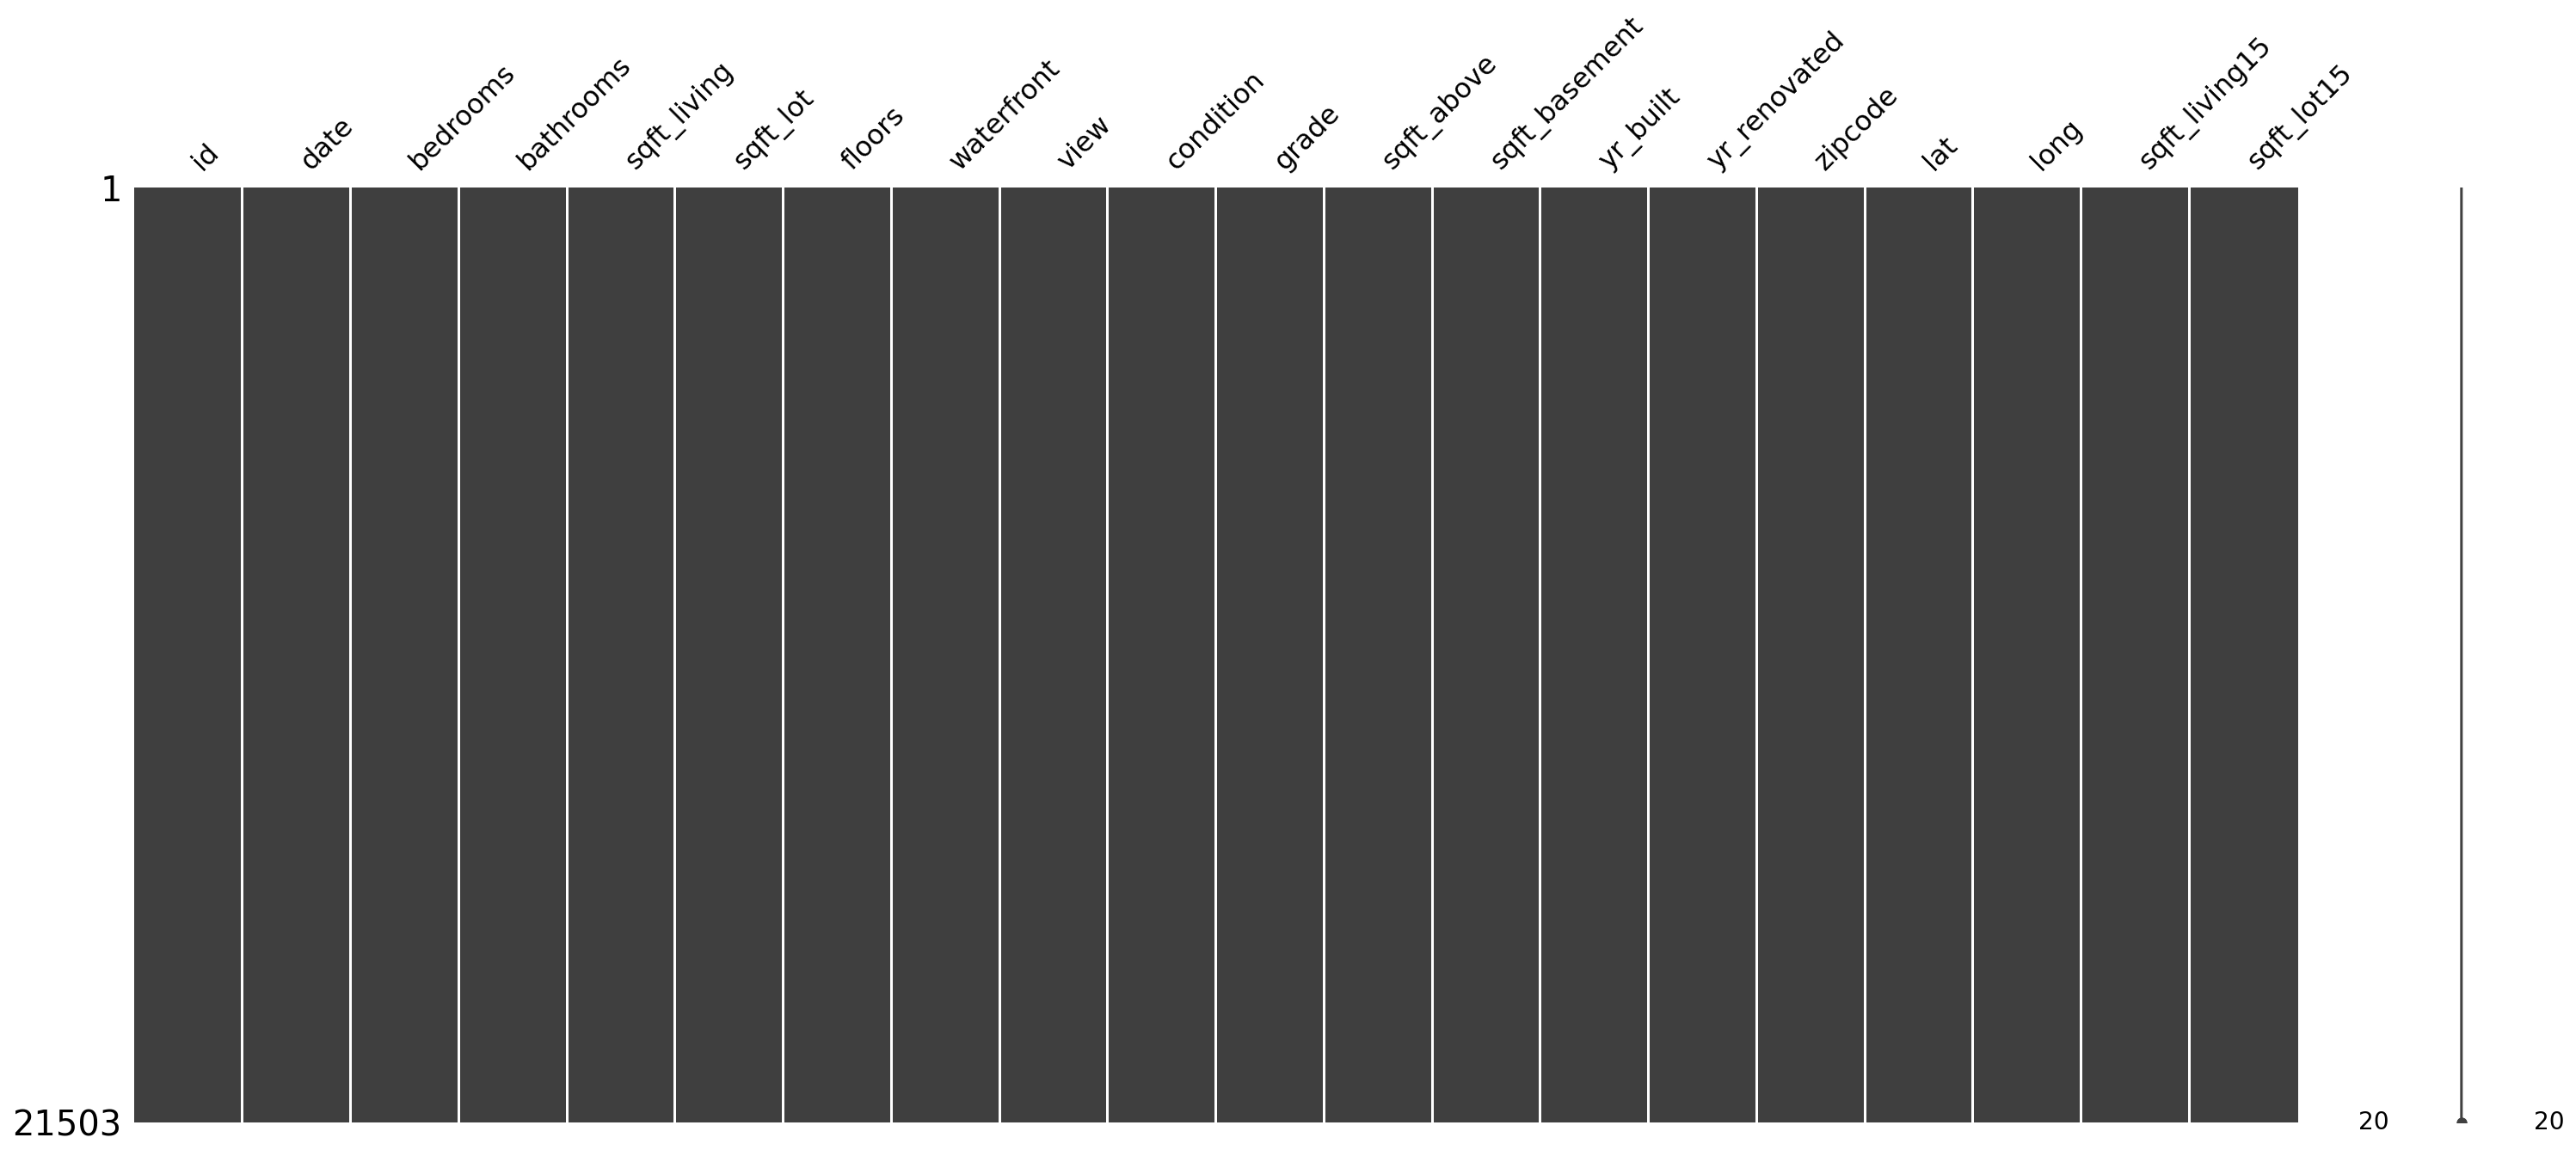

In [10]:
msno.matrix(data)

In [12]:
data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [id, date, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

In [14]:
data[data['id'].isnull()]

Empty DataFrame
Columns: [id, date, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

In [15]:
len(data.loc[pd.isnull(data['id']),'id'].values)

0

In [16]:
for c in data.columns:
    print(len(data.loc[pd.isnull(data[c]),c].values))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [17]:
# ✓ id, date 변수 정리
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [18]:
data['date']

0       20141013T000000
1       20150225T000000
2       20150218T000000
3       20140627T000000
4       20150115T000000
5       20150403T000000
6       20140527T000000
7       20140528T000000
8       20141007T000000
9       20150312T000000
10      20150124T000000
11      20140731T000000
12      20140529T000000
13      20141205T000000
14      20150424T000000
15      20140514T000000
16      20140826T000000
17      20140516T000000
18      20141120T000000
19      20141103T000000
20      20140626T000000
21      20141201T000000
22      20141110T000000
23      20140624T000000
24      20141110T000000
25      20141203T000000
26      20140613T000000
27      20141230T000000
28      20150213T000000
29      20140620T000000
             ...       
6438    20140801T000000
6439    20140617T000000
6440    20140509T000000
6441    20150331T000000
6442    20150227T000000
6443    20140711T000000
6444    20140825T000000
6445    20141209T000000
6446    20150217T000000
6447    20140811T000000
6448    20141015

In [19]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

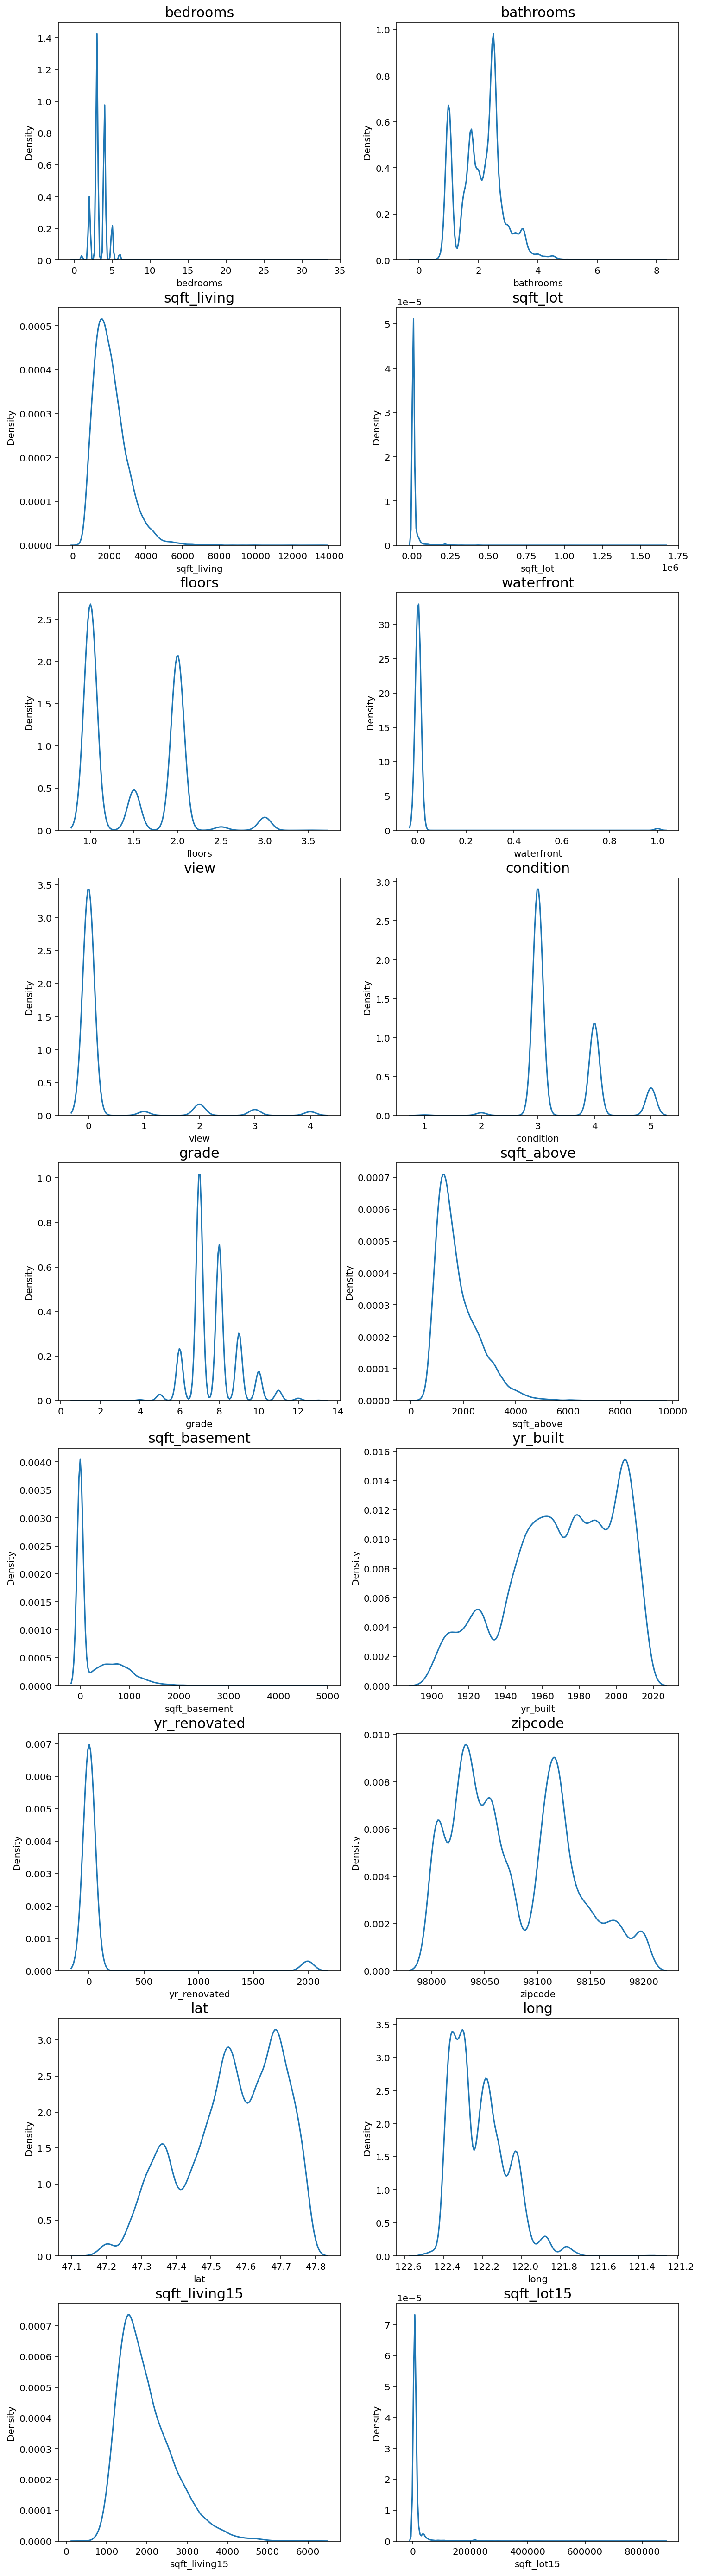

In [20]:
# ✓ 각 변수들의 분포 확인
fig,ax = plt.subplots(9,2,figsize=(12,50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]],ax=ax[row][col])
        ax[row][col].set_title(columns[count],fontsize=15)
        count +=1
        if count==19:
            break

In [23]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

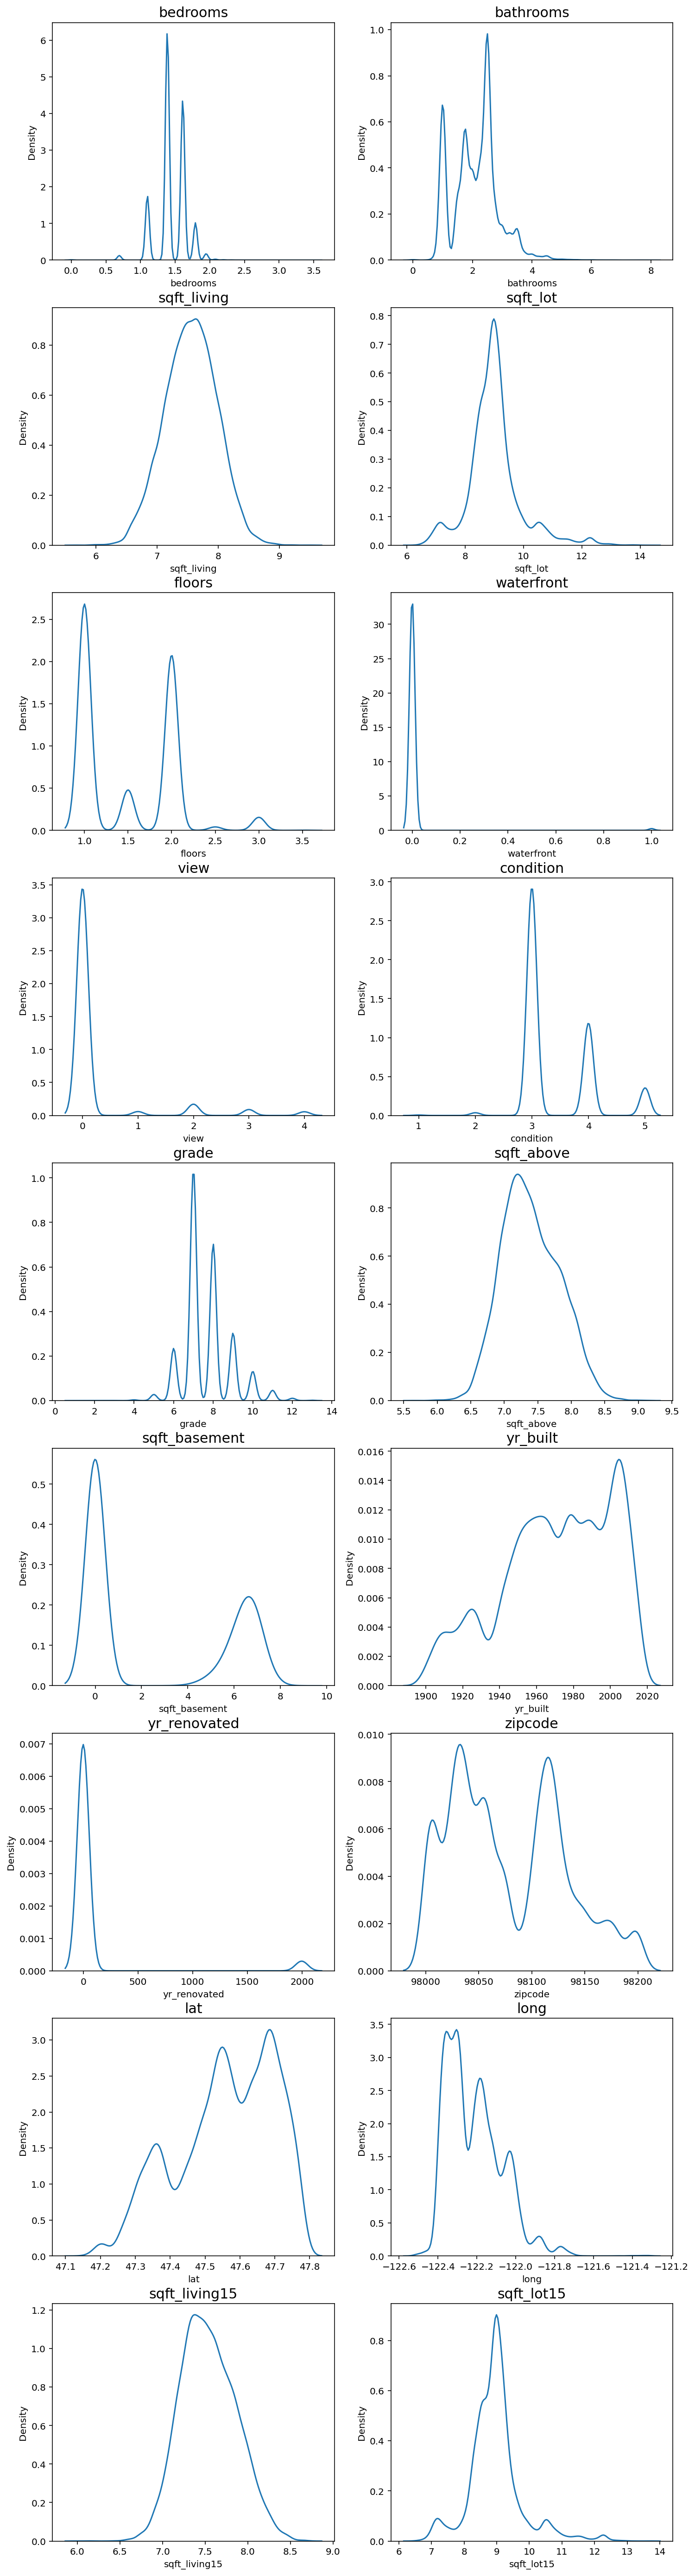

In [24]:
# ✓ 각 변수들의 분포 확인
fig,ax = plt.subplots(9,2,figsize=(12,50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]],ax=ax[row][col])
        ax[row][col].set_title(columns[count],fontsize=15)
        count +=1
        if count==19:
            break

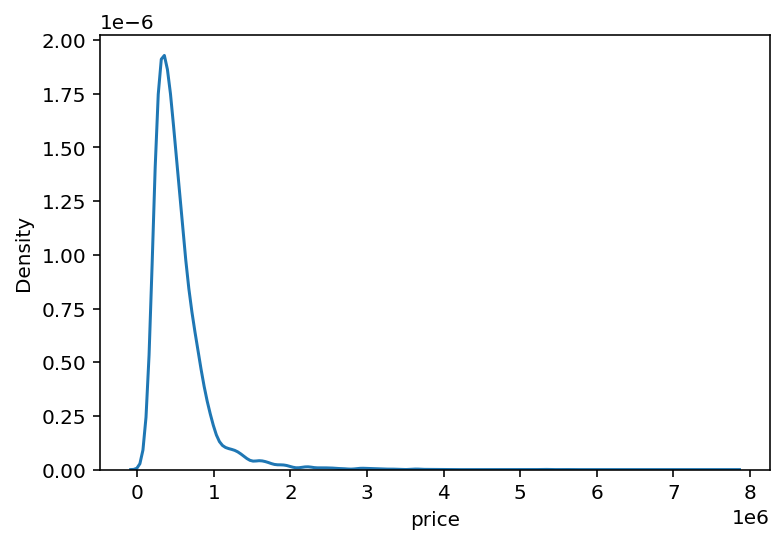

In [26]:
sns.kdeplot(y)
plt.show()

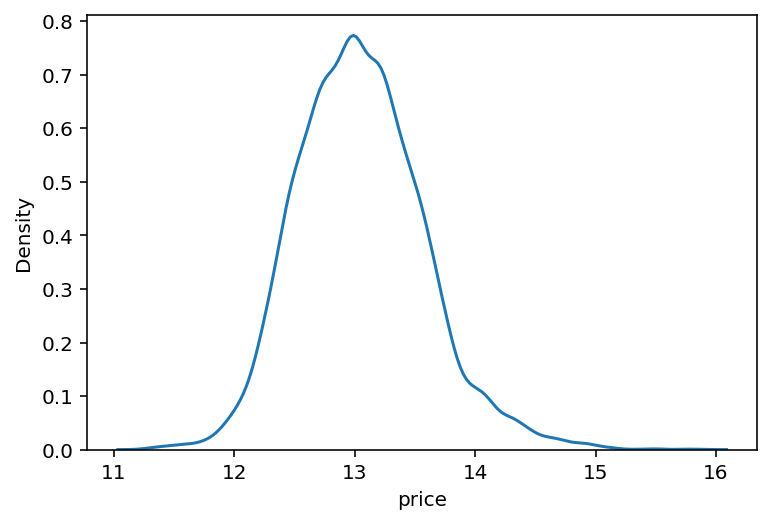

In [27]:
y_log_transformation = np.log1p(y)
sns.kdeplot(y_log_transformation)
plt.show()

In [28]:
sub = data.iloc[train_len:,:]
x = data.iloc[:train_len,:]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 3-7. 일단 제출하고 시작해! Baseline 모델 (4) 모델 설계

In [29]:
# ✓ Average Blending
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
# ✓ Cross Validation
